# Synfire chain growth

The aim of this notebook is to investigate the formation of wide synfire chains via Ila Fiete's recipe of STDP + heterosynaptic competition + correlated input.

## Network Architecture
Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.

# Code

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=2e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, T_E=.002, T_I=.002,
    
    W_U_E=1.4e-4,
    W_MAX=2.5e-4,
    M=1.,
    ETA=0.0002,
    EPSILON=0.,
    
    W_E_I_R=0.003e-3,
    W_I_E_R=0.014e-3,
    
    N_EXC=50,
    N_INH=1,
    
    DRIVING_HZ=2, # 10 Hz lambda Poisson input to system
    N_DRIVING_CELLS=50,
    PROJECTION_NUM=1,
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


## Synaptic weight change under STDP rule

In [2]:
def bin_occurrences(occurrences, min_idx=0, max_idx=None, bin_size=1):
    if max_idx is None:
        max_idx = occurrences.max() + 1
    binned = np.zeros(max_idx - min_idx)
    for n in occurrences:
        if n >= max_idx or n < min_idx:
            raise IndexError(f'index {n} is out of bounds for min {min_idx} and max {max_idx}')
        binned[n - min_idx] += 1
    return binned

def calc_degree_dist(mat):
    degree_freqs = bin_occurrences(np.count_nonzero(mat, axis=1))
    return np.arange(len(degree_freqs)), degree_freqs

# Full chain

### Helper functions for defining network connectivity

In [3]:
def rand_n_ones_in_vec_len_l(n, l):
    if n > l:
        raise ValueError('n cannot be greater than l')
    vec = np.concatenate([np.ones(n, int), np.zeros(l - n, int)])
    return vec[np.random.permutation(l)]

def dropout_on_mat(mat, percent):
    dropout_indices = rand_bin_array_with_percentage_ones(mat.shape[1], int((1 - percent) * mat.shape[1]))
    m = copy(mat)
    for idx, val in enumerate(dropout_indices):
        m[:, idx] = val * m[:, idx]
    return m

In [4]:
def graph_weight_matrix(mat, title, v_max=None, ax=None):
    mat = copy(mat)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
    
    ax.matshow(mat, vmin=0, vmax=v_max if v_max is not None else mat.max(), cmap='gray')
    ax.set_title(title)
    set_font_size(ax, 14)

def graph_weights(w_r, w_u, v_max=None):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
    
    graph_weight_matrix(w_r['E'], 'W_R[E]\n', v_max=v_max, ax=axs[0, 0])
    graph_weight_matrix(w_r['I'], 'W_R[I]\n', v_max=v_max, ax=axs[0, 1])
    graph_weight_matrix(w_u['E'], 'W_U[E]\n', v_max=v_max, ax=axs[1, 0])
    graph_weight_matrix(w_u['I'], 'W_U[I]\n', v_max=v_max, ax=axs[1, 1])
    
def col_in_used(col, used, all_chains):
    if col in used:
        for c_idx, chain in enumerate(all_chains):
            if len(chain) > 0 and col == chain[0]:
                chain.insert(0, col)
            used.append(col)
        return True
    return False
    
def process_col(col, max_locs, curr_chain, all_chains, used):
    receiving = max_locs[col]
    if receiving != -1:
        if not col_in_used(receiving, used, all_chains):
            curr_chain.append(receiving)
            used.append(receiving)
            process_col(receiving, max_locs, curr_chain, all_chains, used)
    
def sort_mat(mat, min_val):
    max_locs_per_col = np.argmax(mat, axis=0)
    max_locs_per_col[np.max(mat, axis=0) < min_val] = -1
    
    print(max_locs_per_col)
    
    used = []
    all_chains = []
    
    for col in range(mat.shape[1]):
        if not col_in_used(col, used, all_chains):
            curr_chain = [col]
            all_chains.append(curr_chain)
            process_col(col, max_locs_per_col, curr_chain, all_chains, used)
    
    all_chains_pruned = []
    for chain in all_chains:
        if len(chain) > 1:
            all_chains_pruned.append(chain)
    return all_chains_pruned


### Define function for simulating a single set of parameters using three different input UVA frequences

In [5]:
def run_test(m, show_connectivity=True, repeats=1, n_show_only=None, add_noise=True, dropouts=[{'E': 0, 'I': 0}]):
    
    n_cells_driven = m.N_DRIVING_CELLS * m.PROJECTION_NUM
    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ m.W_U_E * np.repeat(np.diag(np.ones(m.N_DRIVING_CELLS)), m.PROJECTION_NUM, axis=0), np.zeros([n_cells_driven, m.N_EXC + m.N_INH]) ],
            [ np.zeros([m.N_EXC + m.N_INH - n_cells_driven, m.N_EXC + m.N_INH + m.N_DRIVING_CELLS]) ],
        ]),

        'I': np.zeros((m.N_EXC + m.N_INH, m.N_DRIVING_CELLS + m.N_EXC + m.N_INH)),
    }
    
    w_initial_max = m.W_MAX / (m.M * m.N_EXC)
    
    e_i_r = np.stack([rand_n_ones_in_vec_len_l(int(m.N_EXC * .7), m.N_EXC) for i in range(m.N_INH)])
    
    i_e_r = np.stack([rand_n_ones_in_vec_len_l(int(m.N_INH * .7), m.N_INH) for i in range(m.N_EXC)])
    
    w_e_e_r = np.ones((m.N_EXC, m.N_EXC)) * w_initial_max
    np.fill_diagonal(w_e_e_r, 0.)
    
    ## recurrent weights
    w_r_base = {
        'E': np.block([
            [ w_e_e_r, np.zeros((m.N_EXC, m.N_INH)) ],
            [ e_i_r * m.W_E_I_R,  np.zeros((m.N_INH, m.N_INH)) ],
        ]),
        'I': np.block([
            [ np.zeros((m.N_EXC, m.N_EXC)), i_e_r * m.W_I_E_R ],
            [ np.zeros((m.N_INH, m.N_EXC)), np.zeros((m.N_INH, m.N_INH)) ],
        ]),
    }
    
    w_r_for_dropouts = []
    for dropout in dropouts:
        w_r = copy(w_r_base)
        # w_r['E'][:, :m.N_EXC] = dropout_on_mat(w_r['E'][:, :m.N_EXC], dropout['E'])
        # w_r['I'][:, m.N_EXC:] = dropout_on_mat(w_r['I'][:, m.N_EXC:], dropout['I'])
        w_r_for_dropouts.append(w_r)
    
    # generate timesteps and initial excitatory input window
    t = np.arange(0, S.T, S.DT)
    
    all_rsps = []

    # run simulation for same set of parameters
    for rp_idx in range(repeats):
        show_trial = (type(n_show_only) is int and rp_idx < n_show_only)

        rsps_for_trial = []

        ## external currents
        if add_noise:
            i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_EXC + m.N_INH) + m.I_EXT_B
        else:
            i_ext = m.I_EXT_B * np.ones((len(t), m.N_EXC + m.N_INH))

        ## inp spks
        spks_u_base = np.zeros((len(t), m.N_DRIVING_CELLS + m.N_EXC + m.N_INH), dtype=int)

        # trigger inputs
        spks_u = copy(spks_u_base)
        spks_u[:, :m.N_DRIVING_CELLS] = np.concatenate([np.random.poisson(m.DRIVING_HZ * S.DT, size=(len(t), 1)) for i in range(m.N_DRIVING_CELLS)], axis=1)
        
        rsps_for_trial = []
        
        for d_idx, dropout in enumerate(dropouts):
            
            w_r_for_dropout = w_r_for_dropouts[d_idx]
            
            w_max = m.W_MAX / m.M
            print(w_max)
            print(np.max(w_r_for_dropout['E']))
#             if show_connectivity:
#                 graph_weights(copy(w_r_for_dropout), copy(w_u), v_max=w_max)

            ntwk = LIFNtwkG(
                c_m=m.C_M_E,
                g_l=m.G_L_E,
                e_l=m.E_L_E,
                v_th=m.V_TH_E,
                v_r=m.E_L_E,
                t_r=m.T_R_E,
                e_s={'E': M.E_E, 'I': M.E_I},
                t_s={'E': M.T_E, 'I': M.T_E},
                w_r=copy(w_r_for_dropout),
                w_u=copy(w_u),
                plasticity_indices=np.arange(m.N_EXC),
                W_max=m.W_MAX,
                m=m.M,
                eta=m.ETA,
                epsilon=m.EPSILON,
            )

            clamp = Generic(
                v={0: np.repeat(m.E_L_E, m.N_EXC + m.N_INH)}, spk={})

            # run smln
            rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
            
            if show_connectivity:
                graph_weights(rsp.ntwk.w_r, rsp.ntwk.w_u, v_max=w_max)
            
            w_r_e = rsp.ntwk.w_r['E'][:m.N_EXC, :m.N_EXC]
            print(np.max(w_r_e))
            graph_weight_matrix(w_r_e, 'Exc->Exc Weights\n', v_max=w_max)
            graph_weight_matrix(np.sqrt(np.dot(w_r_e, w_r_e.T)), 'W * W.T \n', v_max=w_max)
            print(sort_mat(w_r_e, w_max * 0.2))
                
            rsps_for_trial.append({
                'spks_t': copy(rsp.spks_t),
                'spks_c': copy(rsp.spks_c),
                'spks_u': spks_u.nonzero(),
                'w_r': copy(rsp.ntwk.w_r)
            })
        all_rsps.append(rsps_for_trial)
    return all_rsps

In [6]:
def build_tg_density_graph(m, num_timegroups, spks_t, t_indices, tg_indices):
    tgs_at_t = np.zeros((int(S.T/S.DT), num_timegroups))
    ts = spks_t[t_indices]
    for t, tg_idx in zip(ts, tg_indices) :
        if tg_idx % m.N_NUCLEI == 0:
            tgs_at_t[int(t / S.DT), tg_idx] += 1
    return tgs_at_t

In [7]:
def quick_plot(m, repeats=1, show_connectivity=True, n_show_only=None, add_noise=True, dropouts=[{'E': 0, 'I': 0}]):
    all_rsps = run_test(m, show_connectivity=show_connectivity, repeats=repeats,
                        n_show_only=n_show_only, add_noise=add_noise, dropouts=dropouts)
    
    colors = ['black', 'blue', 'green', 'purple', 'brown']
        
    for idx_r, rsps in enumerate(all_rsps):
        for idx_do, rsp_for_dropout in enumerate(rsps):
            
            raster = np.stack([rsp_for_dropout['spks_t'], rsp_for_dropout['spks_c']])

            exc_raster = raster[:, raster[1, :] < m.N_EXC]
            inh_raster = raster[:, raster[1, :] >= m.N_EXC]

            show_trial = (type(n_show_only) is None) or (type(n_show_only) is int and idx_r < n_show_only)
            print(show_trial)
            # if show_trial:
            gs = gridspec.GridSpec(1, 1)
            fig = plt.figure(figsize=(18, 6), tight_layout=True)
            axs = [fig.add_subplot(gs[0])]

            axs[0].scatter(exc_raster[0, :] * 1000, exc_raster[1, :], s=1, c='black', zorder=0, alpha=1)
            axs[0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='red', zorder=0, alpha=1)

            axs[0].set_ylim(-1, m.N_EXC + m.N_INH)
            axs[0].set_xlim(0, S.T * 1000)
            axs[0].set_ylabel('Cell Index')
            axs[0].set_xlabel('Time (ms)')
            
            set_font_size(axs[0], 14)
    return all_rsps

0.00025
5e-06
0.00025
[13 -1 -1 20 10 -1 -1 42 -1 22 -1 -1 23 12 -1  0 36 24 31 -1  1 -1 29 27
  8 17 -1 -1 19 34 -1 25 48 46 -1 -1 -1 -1 -1 49  6 -1 -1 -1 -1 -1 28  2
 33 43]
[[0, 13, 12, 23, 27], [3, 20, 1], [4, 10], [7, 42], [9, 22, 29, 34], [15, 0], [16, 36], [17, 24, 8], [18, 31, 25, 17], [19, 19], [28, 19], [32, 48, 33, 46, 28], [39, 49, 43], [40, 6], [47, 2]]
False


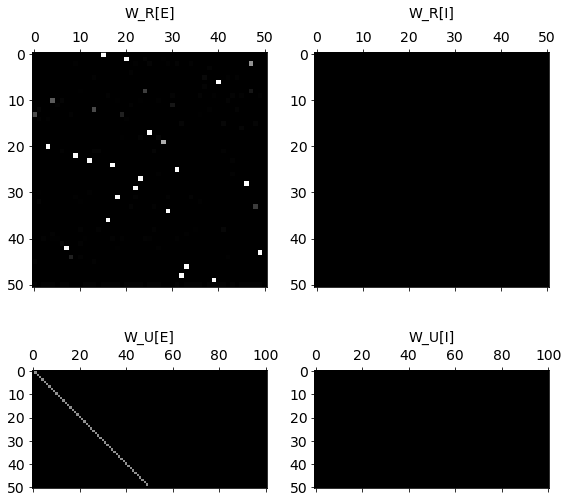

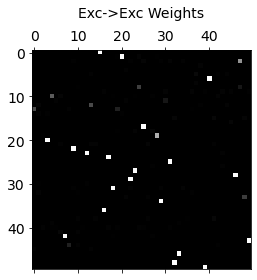

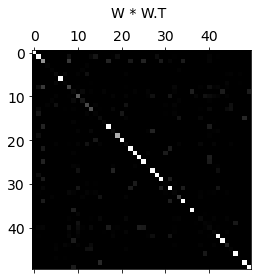

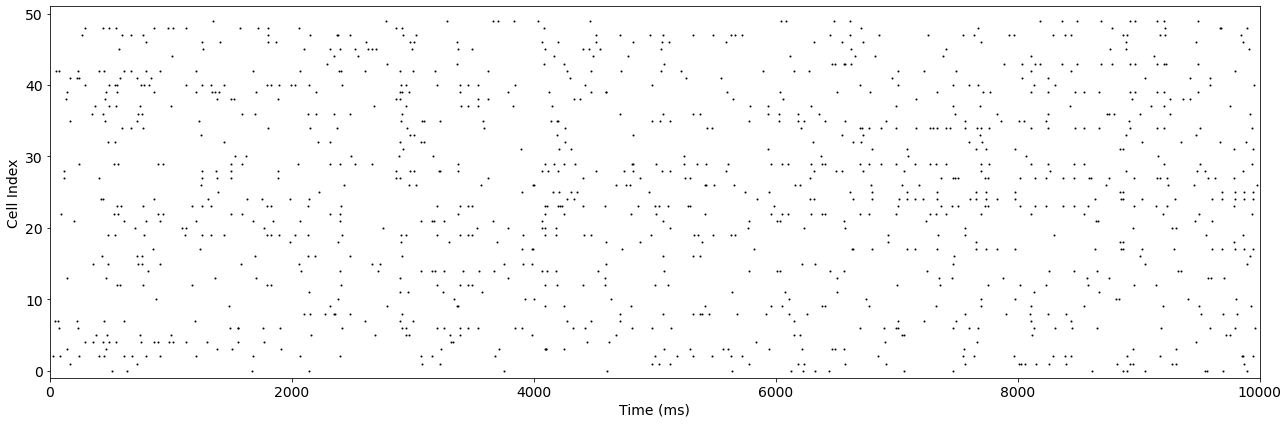

In [8]:
S.T = 10
m2 = copy(M)
m2.EPSILON = 0.05
m2.ETA = 0.01
all_rsps = quick_plot(m2)

0.00025
5e-06
0.00025
[22 -1  8 -1 -1 35 -1 43 12 18 -1 -1 10 -1 49 17 39 13  7 30  2 23 -1 -1
 -1 -1 21 -1 -1 -1 27 -1 -1  9 25 -1 -1 42 -1 -1 37  5  1 -1 34 40 29 -1
 -1 -1]
[[0, 22], [2, 8, 12, 10], [5, 35], [7, 43], [9, 18, 7], [14, 49], [15, 17, 13], [16, 39], [19, 30, 27], [20, 2], [21, 23], [25, 25], [26, 21], [33, 9], [34, 25], [37, 37, 42, 1], [40, 37], [41, 5], [44, 34], [45, 40], [46, 29]]
False


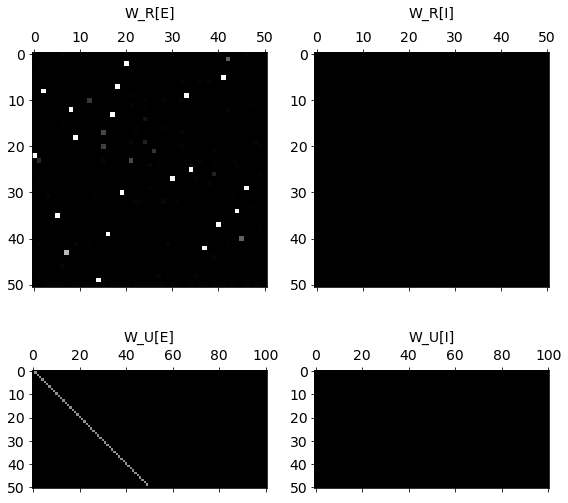

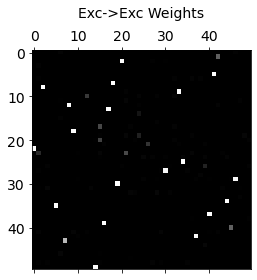

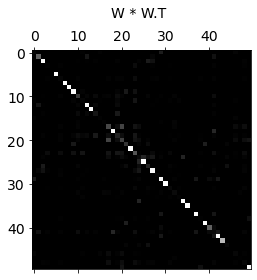

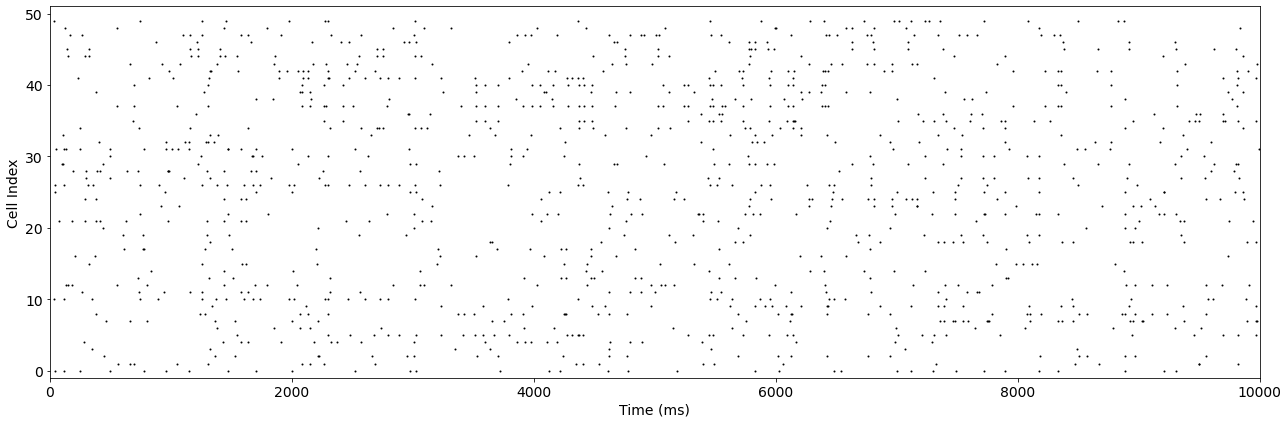

In [11]:
S.T = 10
m2 = copy(M)
m2.EPSILON = 0.05
m2.ETA = 0.01
all_rsps = quick_plot(m2)

0.00025
5e-06
0.0002491098342750784
[-1 49 -1  2 -1  1 -1 -1 40 15 -1 -1 -1 40 -1 -1 31 -1 -1 -1 -1 35  9  0
 13  3 -1 -1 -1  5  6 -1 -1 -1 -1  4  7 -1 24 14 -1 -1 25 -1 41 -1 14 17
 -1 48]
[[1, 1, 49, 48], [2, 2], [3, 3, 2], [5, 1], [8, 40], [9, 15], [13, 13], [14, 14], [16, 31], [21, 35, 4], [22, 9], [23, 0], [24, 13], [25, 3], [29, 5], [30, 6], [36, 7], [38, 24], [39, 14], [42, 25], [44, 41], [47, 17]]
False


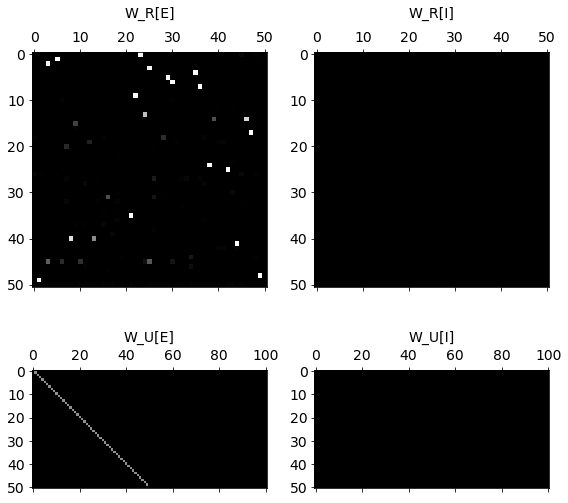

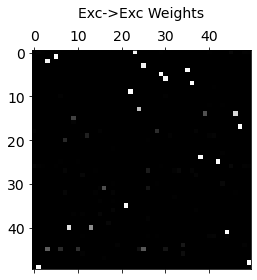

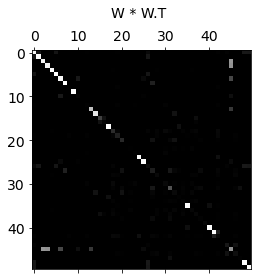

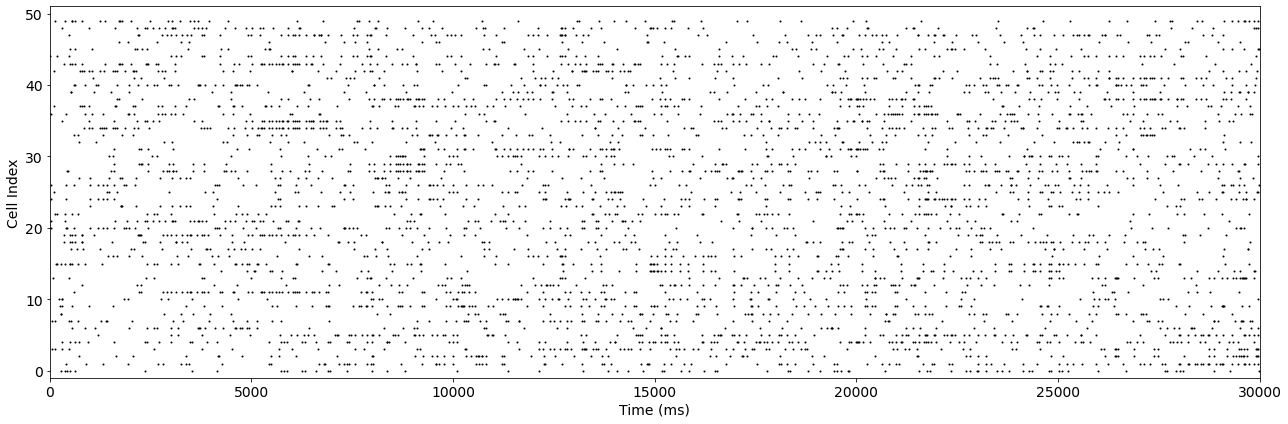

In [12]:
S.T = 30
m2 = copy(M)
m2.EPSILON = 0.05
m2.ETA = 0.01
all_rsps = quick_plot(m2)

0.00025
5e-06
0.00025
[-1  4 -1 -1 41 -1 -1 -1 22 -1  8 21 34 20 -1 10 25 -1 -1 -1 23 -1 24 -1
 -1 -1 -1 -1 -1 26 -1 -1 -1 40 -1 -1  1 -1 33 43 18 -1 -1 27 -1 15 12 14
 17  2]
[[1, 4, 41], [8, 8, 22, 24], [10, 10, 8], [11, 21], [12, 34], [13, 20, 23], [15, 10], [16, 25], [29, 26], [33, 40, 18], [36, 1], [38, 33], [39, 43, 27], [45, 15], [46, 12], [47, 14], [48, 17], [49, 2]]
False


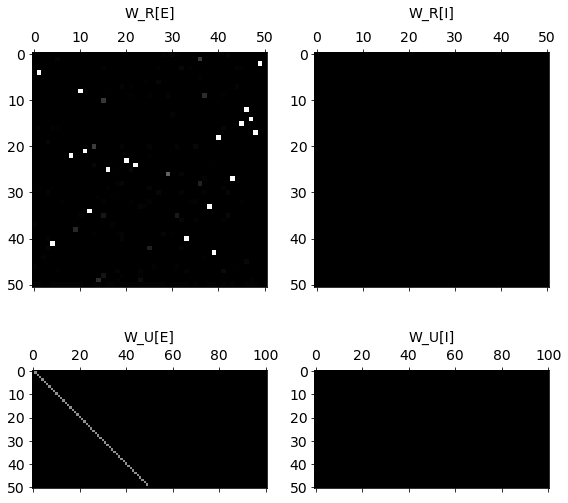

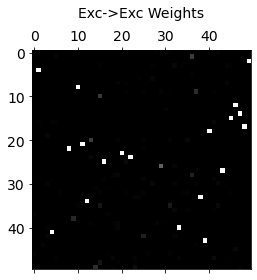

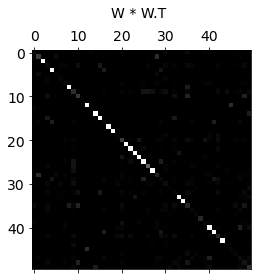

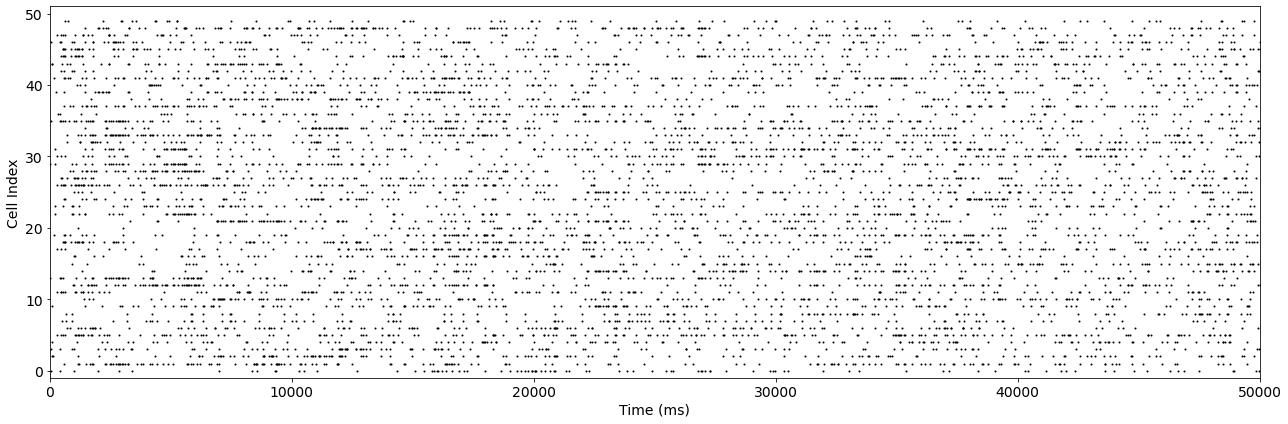

In [13]:
S.T = 50
m2 = copy(M)
m2.EPSILON = 0.05
m2.ETA = 0.01
all_rsps = quick_plot(m2)

0.00025
5e-06
0.00025
[ 3 13 -1 12 -1 25 -1 -1 -1  5 35 36 40 -1 -1 -1 23 -1 17 46 29 -1 34  0
 -1 -1 -1 18 -1 -1 -1  9 33 -1 -1 31 -1 41 -1 -1 32 -1 28 23 15 -1 -1 20
  1 -1]
[[0, 3, 12, 40, 32, 33], [1, 13], [5, 5, 25], [9, 5], [10, 35, 31, 9], [11, 36], [16, 23, 0], [17, 17], [18, 17], [19, 46], [20, 29], [22, 34], [27, 18], [37, 41], [42, 28], [44, 15], [47, 20], [48, 1]]
False


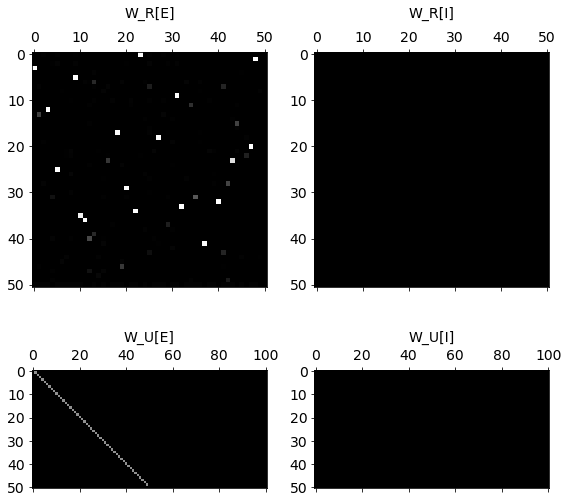

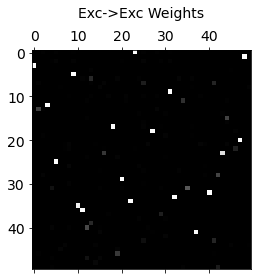

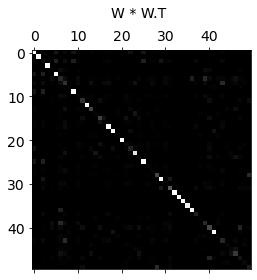

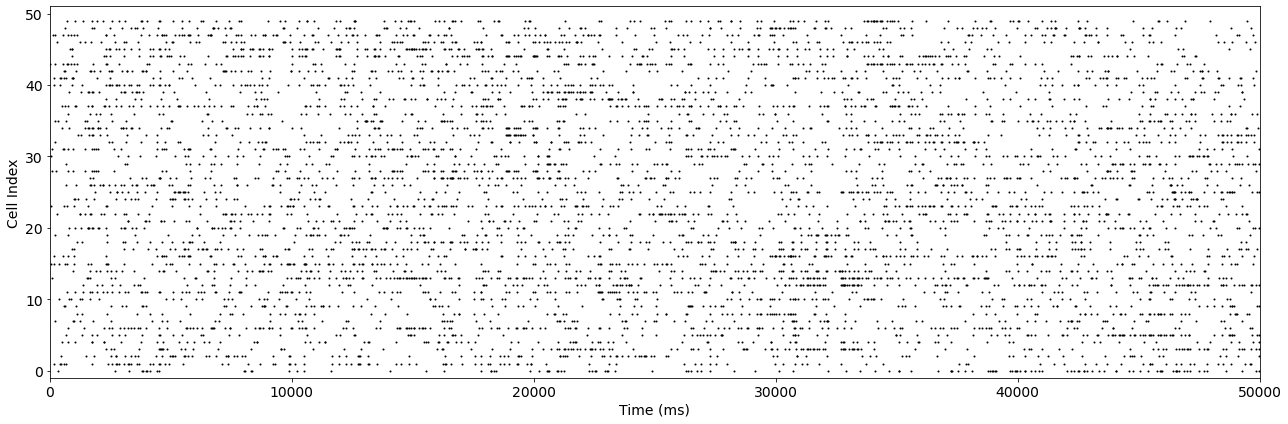

In [14]:
S.T = 50
m2 = copy(M)
m2.EPSILON = 0.05
m2.ETA = 0.008
all_rsps = quick_plot(m2)

In [ ]:
S.T = 50
m2 = copy(M)
m2.EPSILON = 0.05
m2.ETA = 0.01
all_rsps = quick_plot(m2)